In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import scipy.stats as st
import os


In [2]:
# Set working directory to project root
os.chdir("d:\\IPL_Auction_Analytics")
print("Working directory:", os.getcwd())


Working directory: d:\IPL_Auction_Analytics


In [3]:
df = pd.read_csv("data/ipl_with_pressure_flag.csv")
print(df.head())
print(df.shape)


   Match_ID  Match_Date Pitch_Type      Phase  Over  Ball    Bowler  \
0     11935  2023-01-28    Batting  Powerplay     2     1  Bowler B   
1     11935  2023-01-28    Batting  Powerplay     2     2  Bowler B   
2     11935  2023-01-28    Batting  Powerplay     2     3  Bowler B   
3     11935  2023-01-28    Batting  Powerplay     2     4  Bowler B   
4     11935  2023-01-28    Batting  Powerplay     2     5  Bowler B   

   Batter_Avg  Batter_SR  Runs_Conceded  Is_Wicket  is_dot  is_death  \
0       33.46     131.68              0          0    True     False   
1       41.41     138.41              3          0   False     False   
2       26.80     107.22              0          0    True     False   
3        9.31     136.44              0          0    True     False   
4       19.52     105.85              0          1    True     False   

   pressure_applied  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
(4800, 1

In [4]:
df["Pitch_Code"] = df["Pitch_Type"].map({"Batting": 0, "Neutral": 1, "Bowling": 2})
df["Bowler_Code"] = df["Bowler"].map({"Bowler A": 0, "Bowler B": 1})
df["Batter_Avg_Scaled"] = (df["Batter_Avg"] - df["Batter_Avg"].mean()) / df["Batter_Avg"].std()

df.head()


,Match_ID,Match_Date,Pitch_Type,Phase,Over,Ball,Bowler,Batter_Avg,Batter_SR,Runs_Conceded,Is_Wicket,is_dot,is_death,pressure_applied,Pitch_Code,Bowler_Code,Batter_Avg_Scaled
0,11935,2023-01-28,Batting,Powerplay,2,1,Bowler B,33.46,131.68,0,0,True,False,0,0,1,0.204695
1,11935,2023-01-28,Batting,Powerplay,2,2,Bowler B,41.41,138.41,3,0,False,False,0,0,1,1.018946
2,11935,2023-01-28,Batting,Powerplay,2,3,Bowler B,26.80,107.22,0,0,True,False,0,0,1,-0.477432
3,11935,2023-01-28,Batting,Powerplay,2,4,Bowler B,9.31,136.44,0,0,True,False,0,0,1,-2.268784
4,11935,2023-01-28,Batting,Powerplay,2,5,Bowler B,19.52,105.85,0,1,True,False,0,0,1,-1.223060


In [5]:
model = smf.logit(
    formula="Is_Wicket ~ pressure_applied * Bowler_Code + Pitch_Code + Batter_Avg_Scaled",
    data=df
).fit()

model.summary()


Optimization terminated successfully.
         Current function value: 0.222648
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Is_Wicket   No. Observations:                 4800
Model:                          Logit   Df Residuals:                     4794
Method:                           MLE   Df Model:                            5
Date:                Wed, 03 Dec 2025   Pseudo R-squ.:                  0.1277
Time:                        11:55:20   Log-Likelihood:                -1068.7
converged:                       True   LL-Null:                       -1225.2
Covariance Type:            nonrobust   LLR p-value:                 1.602e-65
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -3.1579      0.129    -24.460      0.000      -3.411      -2.905
pressure_applied                -0.4718      0.312     -1.511      0.131      -1.084       0.140
Bowler_Code                     -0.0082      0.148     -0.055      0.956      -0.299       0.283
pressure_applied:Bowler_Code     2.8849      0.346      8.346      0.000       2.207       3.562
Pitch_Code                       0.1708      0.075      2.284      0.022       0.024       0.317
Batter_Avg_Scaled               -0.0654      0.060     -1.094      0.274      -0.182       0.052
================================================================================================
"""

In [6]:
params = model.params
bse     = model.bse
cov     = model.cov_params()
z94 = st.norm.ppf(0.97)   # 94% HDI ≈ 6% two-sided

p_name   = "pressure_applied"
int_name = "pressure_applied:Bowler_Code"

beta_p   = params[p_name]
beta_int = params[int_name]

var_p     = cov.loc[p_name, p_name]
var_int   = cov.loc[int_name, int_name]
cov_p_int = cov.loc[p_name, int_name]

# Bowler A = pressure effect for Bowler A
mean_A = beta_p
se_A   = np.sqrt(var_p)
ciA    = (mean_A - z94*se_A, mean_A + z94*se_A)

# Bowler B = A + interaction
mean_B = beta_p + beta_int
var_B  = var_p + var_int + 2*cov_p_int
se_B   = np.sqrt(var_B)
ciB    = (mean_B - z94*se_B, mean_B + z94*se_B)

# Difference
mean_diff = beta_int
se_diff   = np.sqrt(var_int)
ciD       = (mean_diff - z94*se_diff, mean_diff + z94*se_diff)
prob_B_gt_A = 1 - st.norm.cdf(0, loc=mean_diff, scale=se_diff)

print("Bowler A pressure effect:", mean_A, ciA)
print("Bowler B pressure effect:", mean_B, ciB)
print("Difference:", mean_diff, ciD)
print("P(B > A):", prob_B_gt_A)


Bowler A pressure effect: -0.4718470887884118 (np.float64(-1.0591656541844867), np.float64(0.11547147660766316))
Bowler B pressure effect: 2.41302667033528 (np.float64(2.1249192756065467), np.float64(2.7011340650640134))
Difference: 2.8848737591236917 (np.float64(2.2347849530611628), np.float64(3.5349625651862207))
P(B > A): 1.0


In [7]:
params = model.params
bse     = model.bse
cov     = model.cov_params()
z94 = st.norm.ppf(0.97)   # 94% HDI ≈ 6% two-sided

p_name   = "pressure_applied"
int_name = "pressure_applied:Bowler_Code"

beta_p   = params[p_name]
beta_int = params[int_name]

var_p     = cov.loc[p_name, p_name]
var_int   = cov.loc[int_name, int_name]
cov_p_int = cov.loc[p_name, int_name]

# Bowler A = pressure effect for Bowler A
mean_A = beta_p
se_A   = np.sqrt(var_p)
ciA    = (mean_A - z94*se_A, mean_A + z94*se_A)

# Bowler B = A + interaction
mean_B = beta_p + beta_int
var_B  = var_p + var_int + 2*cov_p_int
se_B   = np.sqrt(var_B)
ciB    = (mean_B - z94*se_B, mean_B + z94*se_B)

# Difference
mean_diff = beta_int
se_diff   = np.sqrt(var_int)
ciD       = (mean_diff - z94*se_diff, mean_diff + z94*se_diff)
prob_B_gt_A = 1 - st.norm.cdf(0, loc=mean_diff, scale=se_diff)

print("Bowler A pressure effect:", mean_A, ciA)
print("Bowler B pressure effect:", mean_B, ciB)
print("Difference:", mean_diff, ciD)
print("P(B > A):", prob_B_gt_A)


Bowler A pressure effect: -0.4718470887884118 (np.float64(-1.0591656541844867), np.float64(0.11547147660766316))
Bowler B pressure effect: 2.41302667033528 (np.float64(2.1249192756065467), np.float64(2.7011340650640134))
Difference: 2.8848737591236917 (np.float64(2.2347849530611628), np.float64(3.5349625651862207))
P(B > A): 1.0


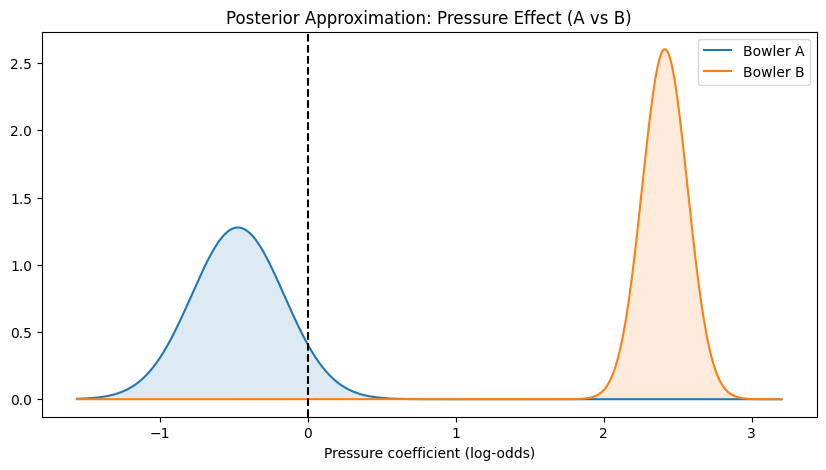

In [9]:
xs = np.linspace(min(ciA[0], ciB[0])-0.5, max(ciA[1], ciB[1])+0.5, 500)

pdf_A = st.norm.pdf(xs, loc=mean_A, scale=se_A)
pdf_B = st.norm.pdf(xs, loc=mean_B, scale=se_B)

plt.figure(figsize=(10,5))
plt.plot(xs, pdf_A, label="Bowler A")
plt.plot(xs, pdf_B, label="Bowler B")
plt.fill_between(xs, pdf_A, alpha=0.15)
plt.fill_between(xs, pdf_B, alpha=0.15)
plt.axvline(0, linestyle='--', color='black')
plt.title("Posterior Approximation: Pressure Effect (A vs B)")
plt.xlabel("Pressure coefficient (log-odds)")
plt.legend()
plt.savefig("figures/pressure_effect_plot.png", dpi=200)
plt.show()


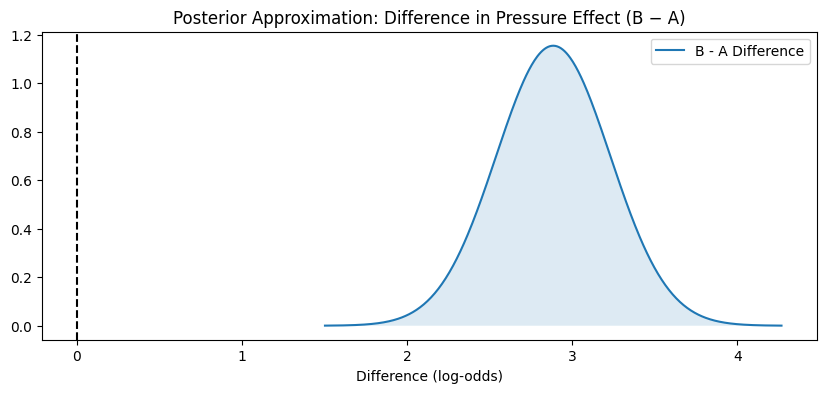

In [10]:
xs2 = np.linspace(mean_diff - 4*se_diff, mean_diff + 4*se_diff, 500)
pdf_diff = st.norm.pdf(xs2, loc=mean_diff, scale=se_diff)

plt.figure(figsize=(10,4))
plt.plot(xs2, pdf_diff, label="B - A Difference")
plt.fill_between(xs2, pdf_diff, alpha=0.15)
plt.axvline(0, linestyle='--', color='black')
plt.title("Posterior Approximation: Difference in Pressure Effect (B − A)")
plt.xlabel("Difference (log-odds)")
plt.legend()
plt.savefig("figures/pressure_effect_diff.png", dpi=200)
plt.show()
